# Top2Vec
#### A topic Modelling analyis of 6000 articles from the gov.uk pertaining to the environment.

In [1]:
from top2vec import Top2Vec
import numpy as np
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import PyPDF2
import json
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDepr

In [2]:
np.random.seed(0)

# Load text data from output.txt
with open('articles.json','r') as f:
    data = json.load(f)

content = [articles['content'] for articles in data]

In [3]:
%%capture
# instantiate Top2Vec model with a document threshold of 0.6
model = Top2Vec(content, min_count=5, embedding_model='universal-sentence-encoder')

2023-05-15 18:05:03,765 - top2vec - INFO - Pre-processing documents for training
2023-05-15 18:05:21,540 - top2vec - INFO - Downloading universal-sentence-encoder model
2023-05-15 18:05:48.438590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-05-15 18:05:48.438626: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-15 18:05:48.438648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cube-540946e2-f90f-4677-8c16-17384461ddc0-6cc8f98c66-7d2lc): /proc/driver/nvidia/version does not exist
2023-05-15 18:05:48.438838: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following 

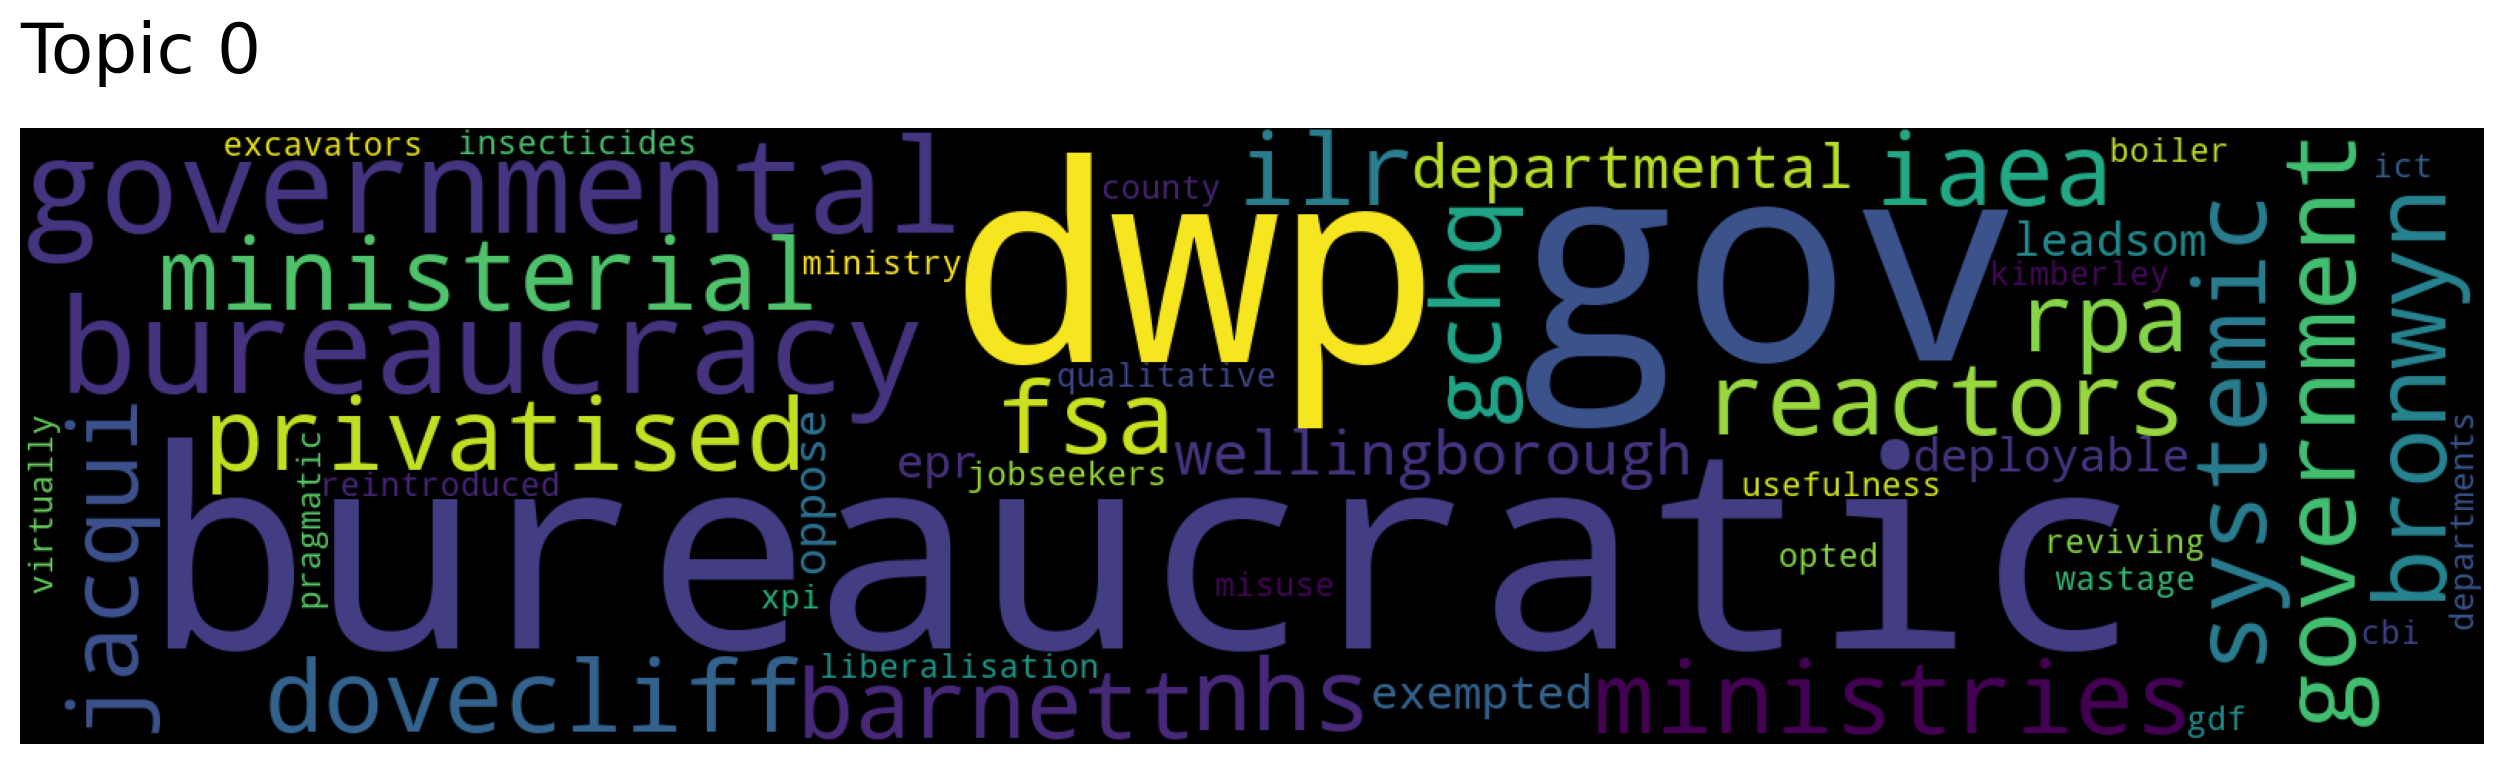

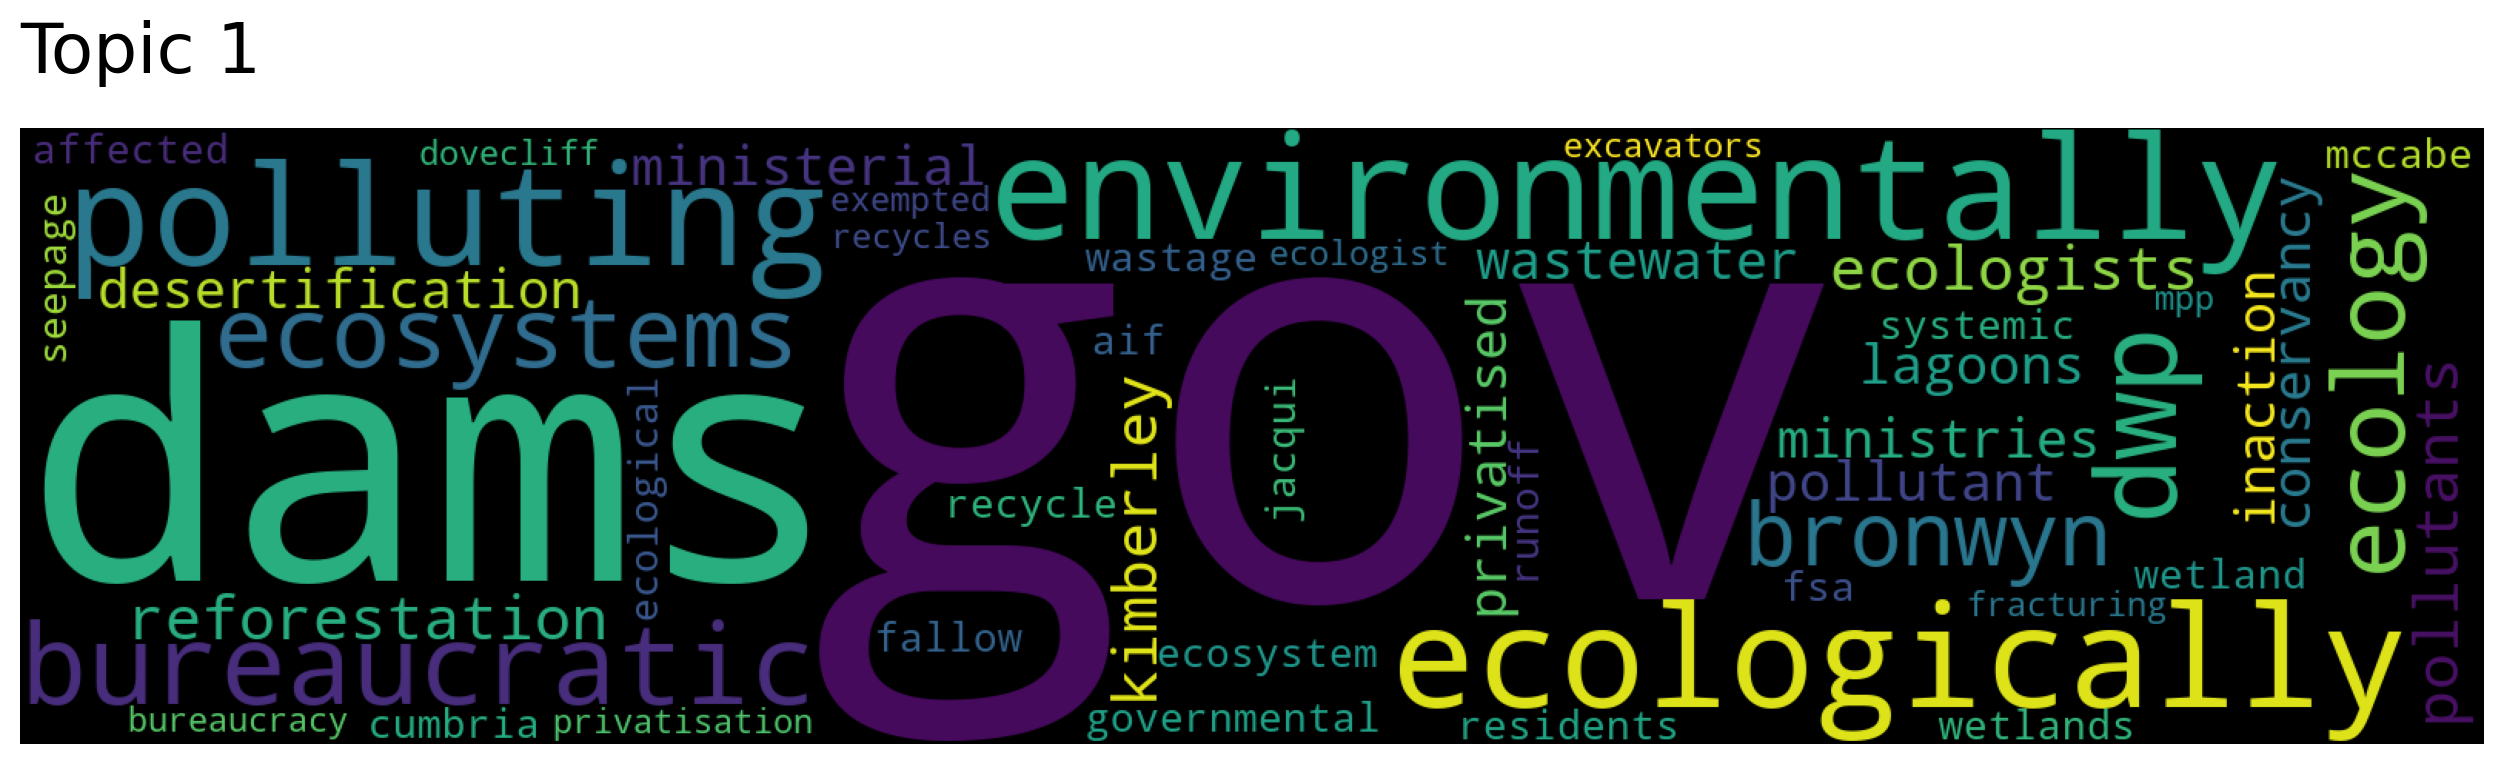

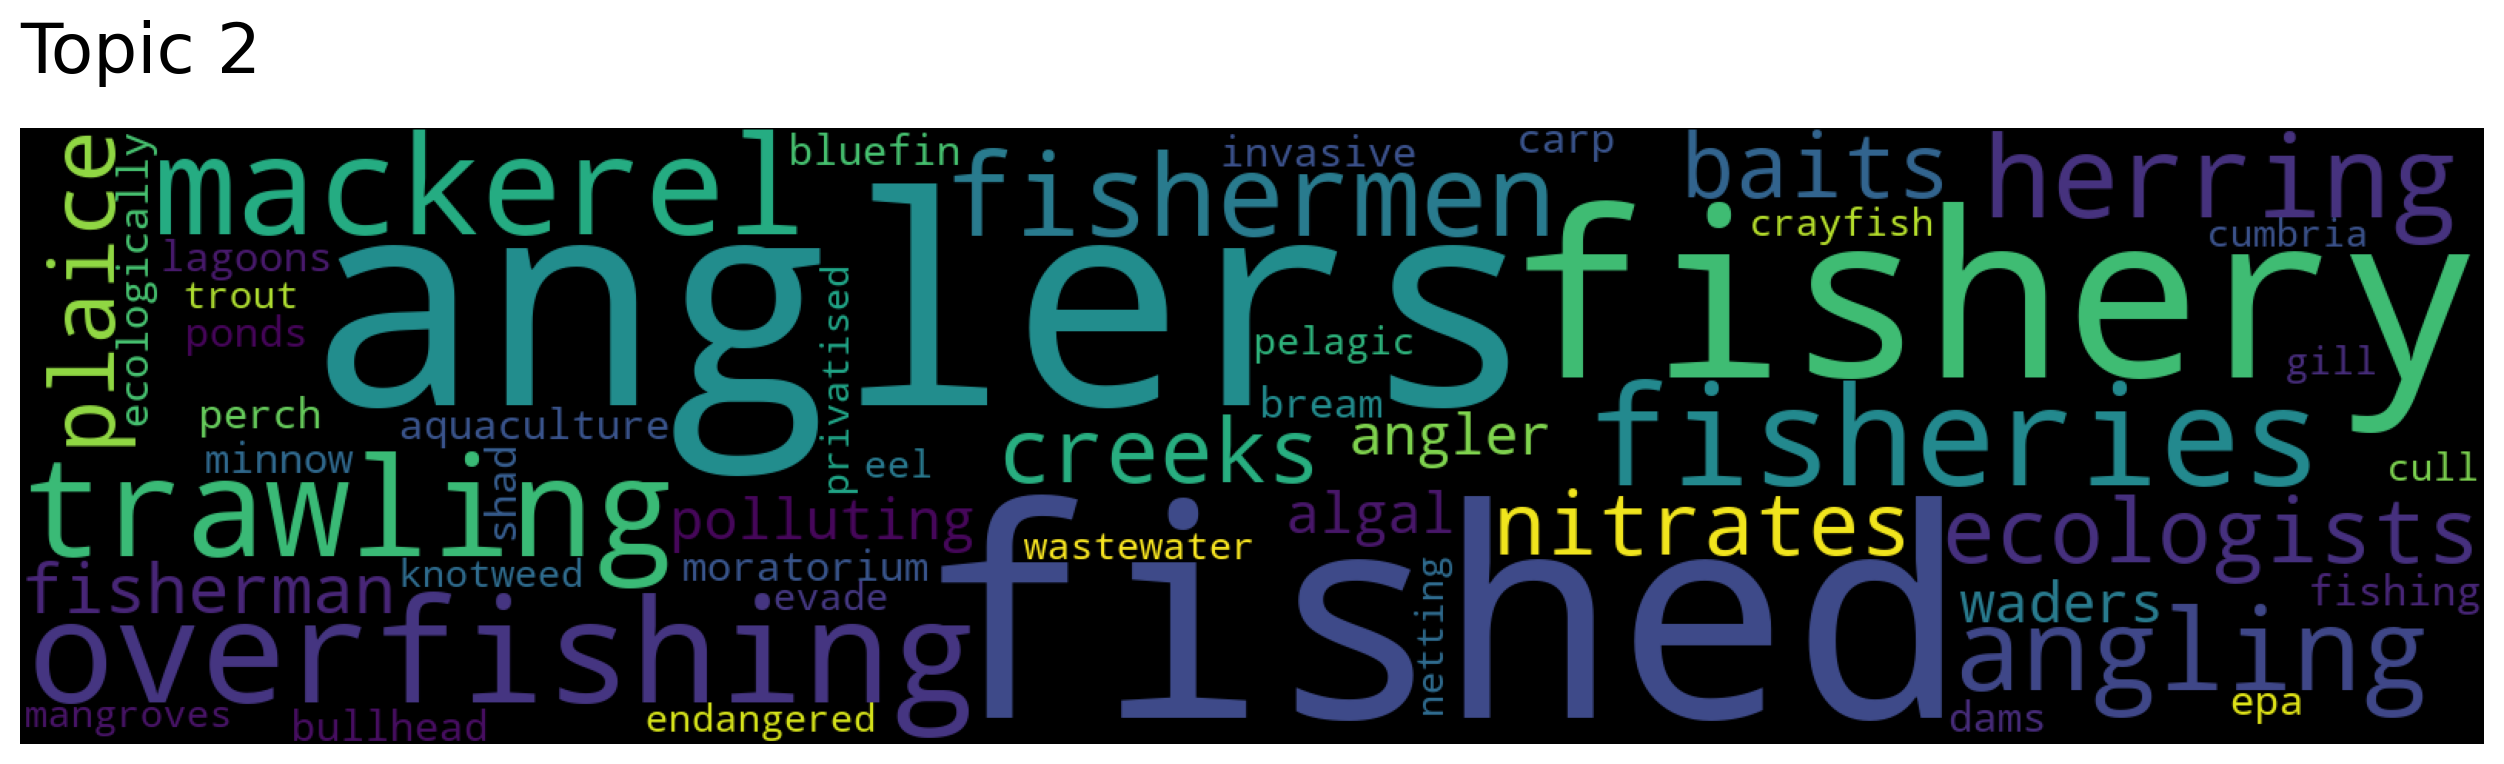

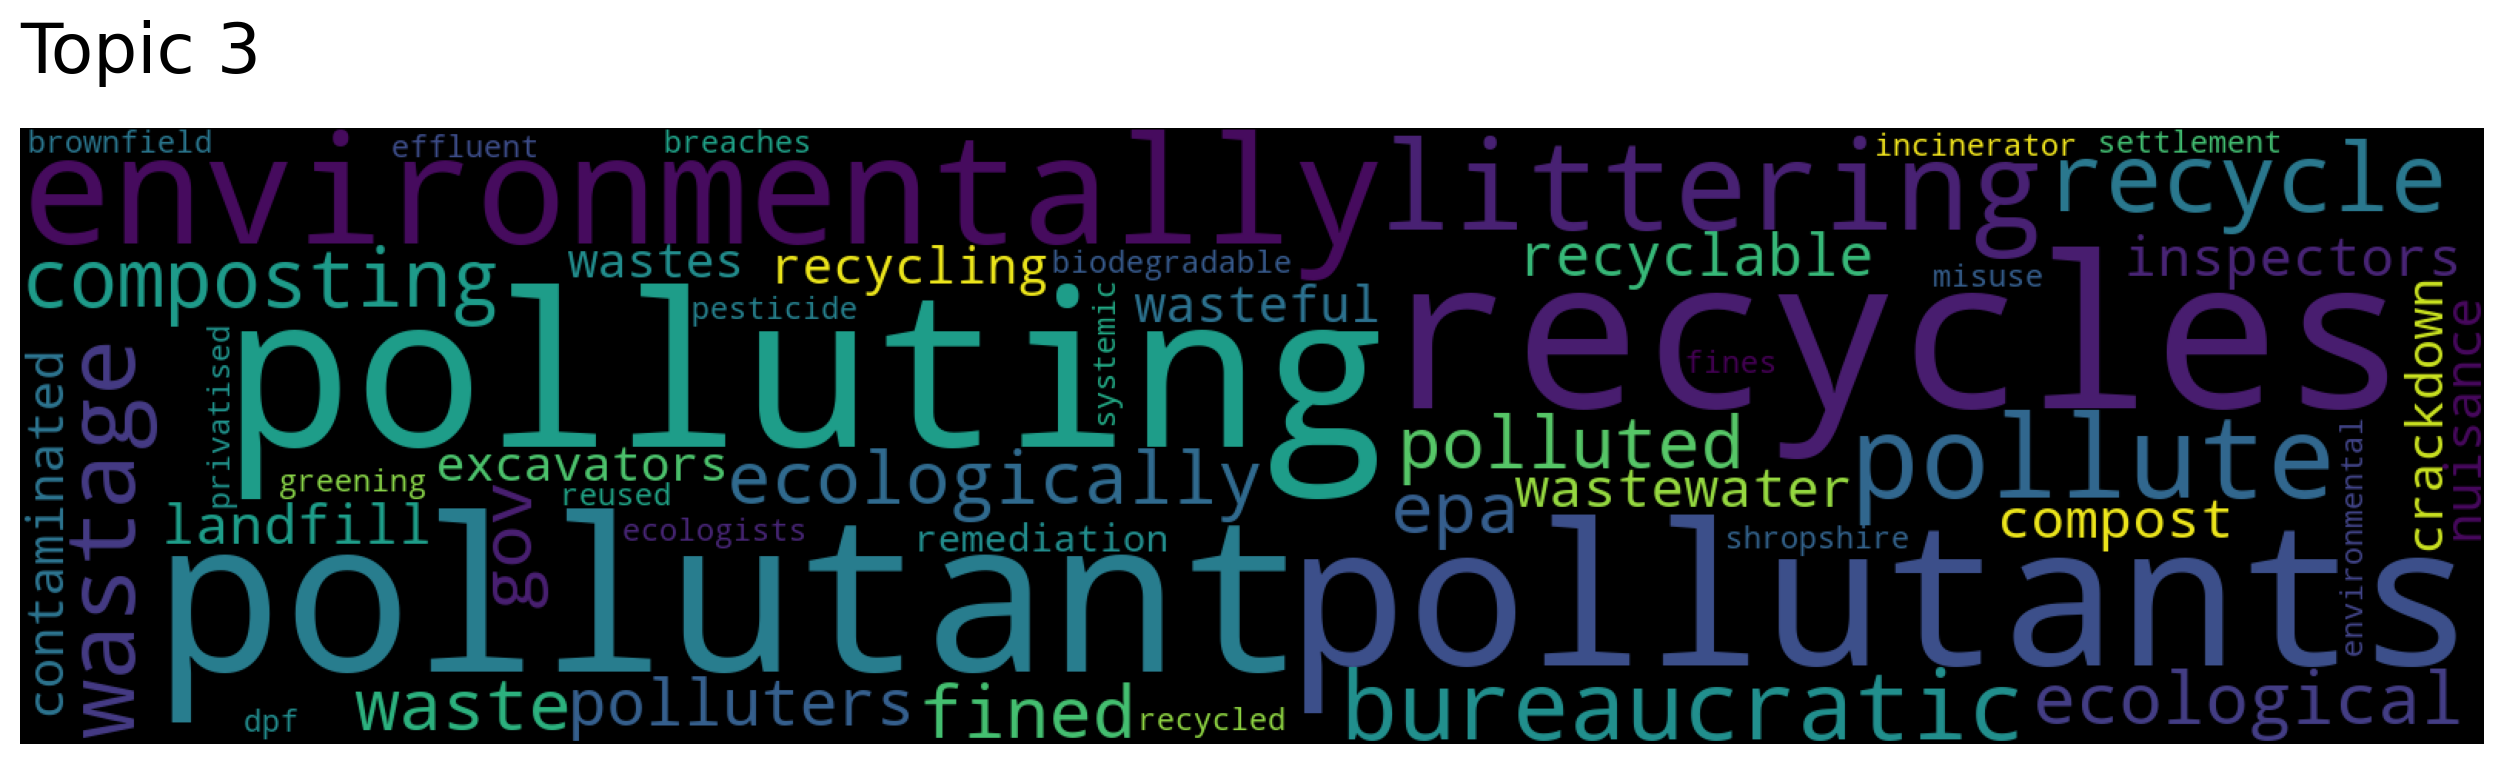

In [4]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
for topic in topic_nums[:4]:
    model.generate_topic_wordcloud(topic)

# Search document by topic

In [24]:
# search for documents by topic
topic_num = 3
num_docs = 40
_, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

# create a dataframe with the document titles and scores
document_list = []
for score, doc_id in zip(document_scores, document_ids):
    article = data[doc_id]
    title = article['title']
    URL = article['url']
    document_list.append({'Title': title.strip(), 'Score': score, 'URL' : URL})

# create a dataframe from the document list
dataframe = pd.DataFrame(document_list)

# print the dataframe
dataframe['Title'][10]

'Farmer fined for illegal waste site'

# Similarity, EA 2021

In [6]:
# open the PDF file and extract the text
pdf_file = open('EA-2021.pdf', 'rb')
pdf_reader = PyPDF2.PdfReader(pdf_file)
environmental_act_text = ""
for page in pdf_reader.pages:
    environmental_act_text += page.extract_text()
    
# create a dictionary with the title and content of the Environmental Act
environmental_act = {
    'title': 'Environmental Act 2021',
    'content': environmental_act_text,
    'url' : 'https://www.legislation.gov.uk/ukpga/2021/30/contents/enacted'
}

# append the Environmental Act dictionary to the list of articles 
data.append(environmental_act)

In [7]:
%%capture
# instantiate Top2Vec model with a document threshold of 0.6
model = Top2Vec(content, min_count=5, embedding_model='universal-sentence-encoder')

2023-05-15 18:06:59,642 - top2vec - INFO - Pre-processing documents for training
2023-05-15 18:07:16,904 - top2vec - INFO - Downloading universal-sentence-encoder model
2023-05-15 18:07:21,295 - top2vec - INFO - Creating joint document/word embedding
2023-05-15 18:07:43,763 - top2vec - INFO - Creating lower dimension embedding of documents
2023-05-15 18:07:54,584 - top2vec - INFO - Finding dense areas of documents
2023-05-15 18:07:54,718 - top2vec - INFO - Finding topics


In [8]:
# Load the Top2Vec model and the documents
documents = content

# Preprocess the documents
tokenized_docs = [simple_preprocess(doc) for doc in documents]

# Create tagged documents for Doc2Vec
tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_docs)]

# Train a Doc2Vec model on the documents
doc2vec_model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=1, epochs=10)

# Get the embeddings for each document
embeddings = np.array([doc2vec_model.infer_vector(doc) for doc in tokenized_docs])

In [9]:
EA_2021_emb = embeddings[5804]

In [10]:
# Compute the cosine similarities between the embeddings
similarities = cosine_similarity(embeddings, EA_2021_emb.reshape(1, -1))

# Create a dataframe with the indices and similarities
df = pd.DataFrame({'index': np.arange(len(similarities)), 'similarity': similarities.flatten()})

# Sort the dataframe by similarity in descending order
df = df.sort_values(by='similarity', ascending=False)

def find_title(x):
    return data[x +1]['title'].strip()

def find_URL(x):
    return data[x +1]['url'].strip()

df['title'] = df.index.map(lambda x:find_title(x))
#df['URL'] = df.index.map(lambda x:find_URL(x))

# Similar documents

In [11]:
df.head()

,index,similarity,title
5804,5804,1.000000,Environmental Act 2021
4238,4238,0.673414,UK supports South African female GreenTech ent...
4551,4551,0.658002,WTO Trade Policy Review of Barbados: UK statement
2706,2706,0.655215,UK takes further action to protect vital marin...
2827,2827,0.650783,Greater Manchester heads way on sustainable fo...


# Disimilar documents

In [12]:
df['title'].tail()

5537     Babcock consortium acquires site licence company
2459    First Annual Congress of FAO Reference Centres...
5355                           Commonwealth Day Statement
4428    Helping instructors with improved immersive tr...
4526    UK signs fisheries agreement with the Faroe Is...
Name: title, dtype: object

# Similarity distribution

<AxesSubplot:>

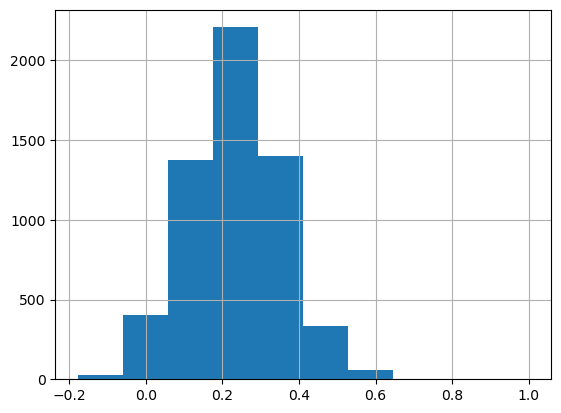

In [13]:
df.similarity.hist()